# Data Cleaning

In [2]:
#Importing pandas library and loading raw dataset#

import pandas as pd

df = pd.read_csv("Alberta_dataset.csv")
df.head()

,CSDUID,CSD,Period,IndicatorSummaryDescription,UnitOfMeasure,OriginalValue
0,4806016,Calgary,1971,Residential Vacancy,NaN,0.067
1,4806016,Calgary,1972,Housing Starts,NaN,7047.000
2,4806016,Calgary,1972,Residential Vacancy,NaN,0.066
3,4806016,Calgary,1973,Housing Starts,NaN,6981.000
4,4806016,Calgary,1973,Residential Vacancy,NaN,0.079


In [3]:
#Cleaning column names#
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)

#Filtering Calgary only#
df = df[df['csd'] == 'Calgary']

#Keeping only the columns needed#
df = df[['period', 'indicatorsummarydescription', 'originalvalue']]

#Pivoting the table from long to wide format#
df_wide = df.pivot_table(
    index='period',
    columns='indicatorsummarydescription',
    values='originalvalue',
    aggfunc='first'
).reset_index()

In [4]:
#Cleaning column names again#
df_wide.columns = (
    df_wide.columns
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("-", "_")
    .str.replace(",", "")
    .str.replace("%", "pct")
)

#Converting numeric columns and sorting by year#
for col in df_wide.columns:
    if col != 'period':
        df_wide[col] = pd.to_numeric(df_wide[col], errors='coerce')

df_wide = df_wide.sort_values('period').reset_index(drop=True)

In [5]:
#Confirming pivoted table#
df_wide.head()
#Checking which indicators actually exist for Calgary#
df_wide.isna().mean().sort_values()


indicatorsummarydescription
period                                        0.000000
residential_vacancy                           0.000000
housing_starts                                0.018519
average_residential_rent_(2_bedroom_units)    0.296296
building_permits_(number_of_permits)          0.388889
                                                ...   
private_households_by_structural_type         0.907407
number_of_farms                               0.925926
cattle_and_calves_(number_of)                 0.925926
cropland_(acres)                              0.925926
pigs_(number_of)                              0.981481
Length: 84, dtype: float64

In [6]:
#Renaming target column#
df_wide = df_wide.rename(columns={
    'average_residential_rent_(2_bedroom_units)': 'rent'
})

In [7]:
#Handling missing values#
df_wide = df_wide.sort_values('period')

#Forward fill slow-changing indicators#
slow_cols = ['population', 'dwelling_units']
df_wide[slow_cols] = df_wide[slow_cols].fillna(method='ffill')

#Interpolate numeric indicators#
df_wide = df_wide.interpolate()

#Drop rows where rent is missing#
df_wide = df_wide.dropna(subset=['rent'])

C:\Users\carlo\AppData\Local\Temp\ipykernel_17116\690303568.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_wide[slow_cols] = df_wide[slow_cols].fillna(method='ffill')


In [8]:
#Setting index to the year#
df_wide = df_wide.set_index('period')
#Confirming pivoted table#
df_wide.head()

indicatorsummarydescription,pct_aboriginal_population,pct_small_businesses,pct_visible_minority,aboriginal_population,air_quality_(percent_high_quality_hours),all_families_income_(median),apprentices_certified,average_latency,rent,average_upload_speed,...,residential_vacancy,sense_of_belonging,single_family_houses_(pct_of_all_housing_units),total_apprentices,total_temp._residents,unemployment_rate,upload_speed_class,vehicle_registrations,violent_crimes_(reported),well_count
period,,,,,,,,,,,,,,,,,,,,,
1987,0.006414,NaN,0.08793,4207.0,NaN,NaN,NaN,NaN,502.0,NaN,...,0.043,NaN,NaN,NaN,NaN,0.097,NaN,NaN,NaN,NaN
1988,0.006898,NaN,0.09318,4639.0,NaN,NaN,NaN,NaN,515.0,NaN,...,0.023,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,NaN
1989,0.007382,NaN,0.09843,5071.0,NaN,NaN,NaN,NaN,555.0,NaN,...,0.012,NaN,NaN,NaN,NaN,0.089,NaN,NaN,NaN,NaN
1990,0.007866,NaN,0.10368,5503.0,NaN,NaN,NaN,NaN,595.0,NaN,...,0.020,NaN,NaN,NaN,NaN,0.085,NaN,NaN,NaN,NaN
1991,0.008350,NaN,0.10893,5935.0,NaN,NaN,NaN,NaN,608.0,NaN,...,0.038,NaN,NaN,NaN,NaN,0.081,NaN,NaN,NaN,NaN


# Feature Engineering

In [9]:
#Creating 1-year Lag features (because rent is influenced by last year conditions)
lag_cols = ['residential_vacancy', 'housing_starts', 'unemployment_rate',
            'population', 'all_families_income_(median)']

for col in lag_cols:
    df_wide[col + '_lag1'] = df_wide[col].shift(1)

In [10]:
#Growth rates (year‑over‑year % change)

growth_cols = ['population', 'all_families_income_(median)', 'housing_starts',
               'building_permits_(value_of_permits)', 'number_of_businesses']

for col in growth_cols:
    df_wide[col + '_growth'] = df_wide[col].pct_change()

In [11]:
#Creating 3-year roll averages because resitential vacancy and housing starts indicators can be noisy#
roll_cols = ['residential_vacancy', 'housing_starts']

for col in roll_cols:
    df_wide[col + '_roll3'] = df_wide[col].rolling(3).mean()

In [12]:
#Creating economic ratios: Housing starts per 1,000 residents, Building permits per dwelling unit & Businesses per capita#

df_wide['starts_per_1000'] = df_wide['housing_starts'] / (df_wide['population'] / 1000)
df_wide['permits_per_dwelling'] = df_wide['building_permits_(number_of_permits)'] / df_wide['dwelling_units']
df_wide['businesses_per_capita'] = df_wide['number_of_businesses'] / df_wide['population']

#Creating a vacancy pressure index#
df_wide['vacancy_pressure'] = 1 / df_wide['residential_vacancy']

In [13]:
df_wide['rent_lag1'] = df_wide['rent'].shift(1)
df_wide = df_wide.dropna()
df_wide['rent_growth'] = df_wide['rent'].pct_change()
#Ensuring the ML model gets a clean dataset
df_wide = df_wide.dropna()


# Building the ML model (from baseline to a better one)

In [ ]:
# Ridge Regression with only key features 


key_features = [
    'rent_lag1',
    'residential_vacancy',
    'housing_starts',
    'all_families_income_(median)',
    'population',
    'building_permits_(value_of_permits)',
    'starts_per_1000',
    'vacancy_pressure'
]

# Build X and y
X = df_wide[key_features]
y = df_wide['rent']

# Use last 5 years as test set
X_train = X.iloc[:-5]
X_test = X.iloc[-5:]
y_train = y.iloc[:-5]
y_test = y.iloc[-5:]

# Train Ridge model
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)

print("Ridge MAE:", mean_absolute_error(y_test, pred_ridge))
print("Ridge RMSE:", np.sqrt(mean_squared_error(y_test, pred_ridge)))
print("Ridge R²:", r2_score(y_test, pred_ridge))

Ridge MAE: 113.9382211229195
Ridge RMSE: 155.16985550973337
Ridge R²: 0.4605294028796446


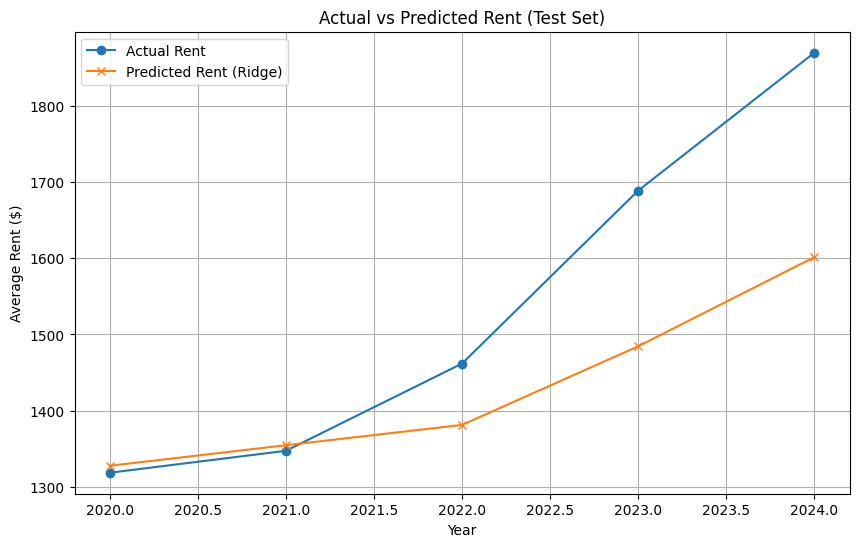

In [15]:
import matplotlib.pyplot as plt

years_test = df_wide.index[-5:]  # last 5 years used as test set

plt.figure(figsize=(10, 6))

plt.plot(years_test, y_test.values, label='Actual Rent', marker='o')
plt.plot(years_test, pred_ridge, label='Predicted Rent (Ridge)', marker='x')

plt.title('Actual vs Predicted Rent (Test Set)')
plt.xlabel('Year')
plt.ylabel('Average Rent ($)')
plt.legend()
plt.grid(True)
plt.show()

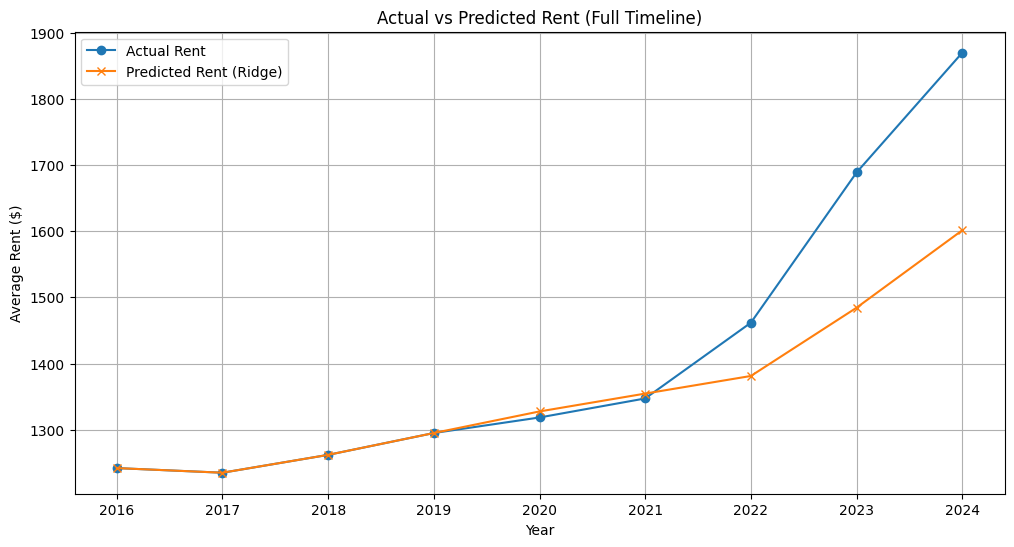

In [37]:
#Plot full timeline with ridge model

full_pred = ridge.predict(X)  
plt.figure(figsize=(12, 6))

plt.plot(df_wide.index, y, label='Actual Rent', marker='o')
plt.plot(df_wide.index, full_pred, label='Predicted Rent (Ridge)', marker='x')

plt.title('Actual vs Predicted Rent (Full Timeline)')
plt.xlabel('Year')
plt.ylabel('Average Rent ($)')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
#Extracting Ridge Coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': ridge.coef_
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
3,all_families_income_(median),1.493095e-03
4,population,1.220953e-03
0,rent_lag1,1.661644e-04
5,building_permits_(value_of_permits),3.612222e-05
7,vacancy_pressure,2.788358e-05
1,residential_vacancy,-6.177635e-08
6,starts_per_1000,-5.689394e-06
2,housing_starts,-7.330119e-03


In [ ]:
#Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

mae = mean_absolute_error(y_test, pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, pred_lr))
r2 = r2_score(y_test, pred_lr)

print("Linear Regression:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

Linear Regression:
MAE: 113.93825303952599
RMSE: 155.1699030264427
R²: 0.4605290724820761


In [26]:
#Lasso Regression model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)

print("Lasso MAE:", mean_absolute_error(y_test, pred_lasso))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, pred_lasso)))
print("Lasso R²:", r2_score(y_test, pred_lasso))

Lasso MAE: 120.57466562815443
Lasso RMSE: 153.78445682552484
Lasso R²: 0.47011948000783044


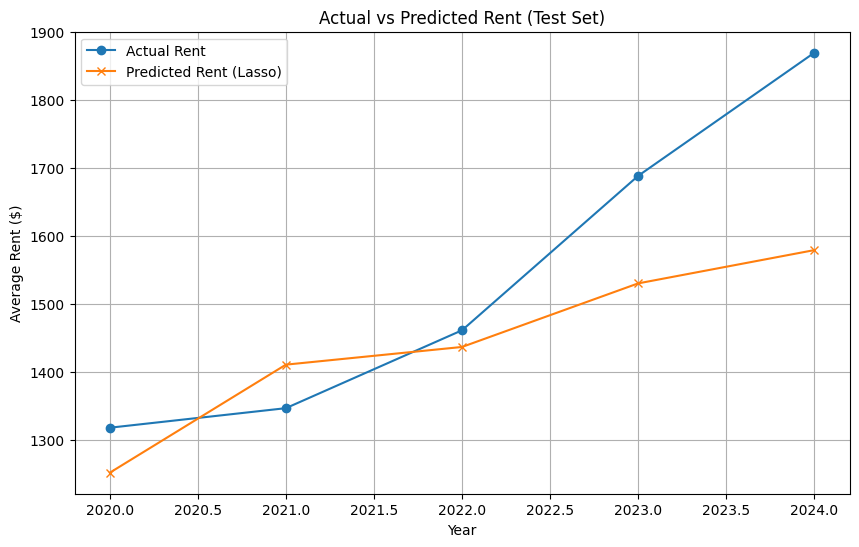

In [20]:
years_test = df_wide.index[-5:]  # last 5 years used as test set

plt.figure(figsize=(10, 6))

plt.plot(years_test, y_test.values, label='Actual Rent', marker='o')
plt.plot(years_test, pred_lasso, label='Predicted Rent (Lasso)', marker='x')

plt.title('Actual vs Predicted Rent (Test Set)')
plt.xlabel('Year')
plt.ylabel('Average Rent ($)')
plt.legend()
plt.grid(True)
plt.show()

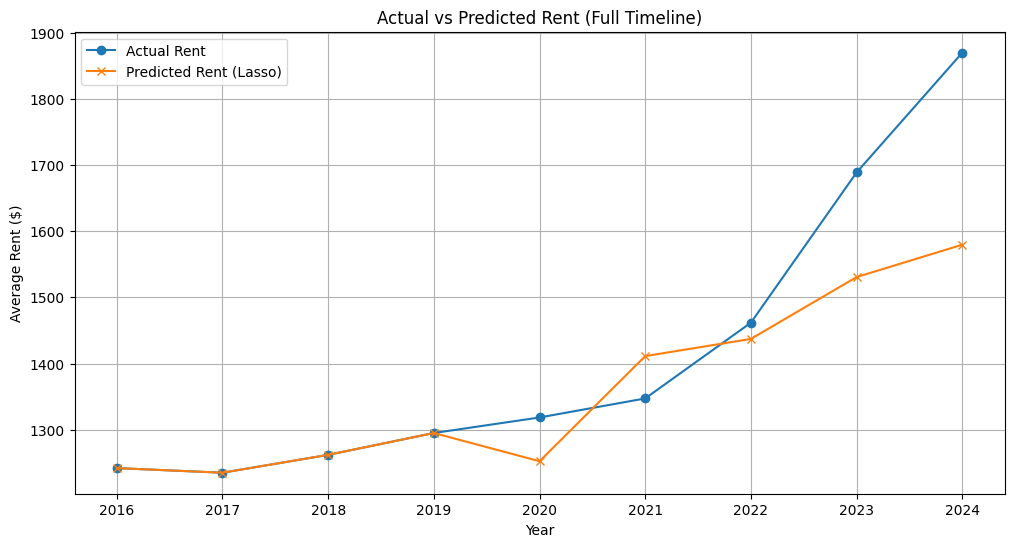

In [ ]:
#Plot full timeline with lasso model

full_pred = lasso.predict(X)   
plt.figure(figsize=(12, 6))

plt.plot(df_wide.index, y, label='Actual Rent', marker='o')
plt.plot(df_wide.index, full_pred, label='Predicted Rent (Lasso)', marker='x')

plt.title('Actual vs Predicted Rent (Full Timeline)')
plt.xlabel('Year')
plt.ylabel('Average Rent ($)')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#Extracting Lasso Coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso.coef_
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
7,vacancy_pressure,0.967458
0,rent_lag1,0.079828
3,all_families_income_(median),0.008467
5,building_permits_(value_of_permits),0.000070
4,population,0.000010
1,residential_vacancy,-0.000000
2,housing_starts,-0.000381
6,starts_per_1000,-0.273905


In [23]:
#Random Forest Regression model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("Random Forest R²:", r2_score(y_test, pred_rf))

Random Forest MAE: 263.45266666666663
Random Forest RMSE: 334.6836192817861
Random Forest R²: -1.5097009865902566


In [ ]:
#Confirming no missing values
print(df_wide.isna().sum().sort_values())

indicatorsummarydescription
pct_aboriginal_population                   0
pct_small_businesses                        0
pct_visible_minority                        0
aboriginal_population                       0
air_quality_(percent_high_quality_hours)    0
                                           ..
permits_per_dwelling                        0
businesses_per_capita                       0
vacancy_pressure                            0
rent_lag1                                   0
rent_growth                                 0
Length: 101, dtype: int64


## Final Model Pipeline (Training & Saving)
This section trains the final Lasso pipeline and saves it as a .pkl file.
If you've already trained and saved the model, you can skip this cell.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso  # Lasso or Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

key_features = [
    'rent_lag1',
    'residential_vacancy',
    'housing_starts',
    'all_families_income_(median)',
    'population',
    'building_permits_(value_of_permits)',
    'starts_per_1000',
    'vacancy_pressure'
]

X = df_wide[key_features]
y = df_wide['rent']

X_train = X.iloc[:-5]
X_test = X.iloc[-5:]
y_train = y.iloc[:-5]
y_test = y.iloc[-5:]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=.01))  # Lasso(alpha=.01) or Ridge(alpha=1.0)
])

pipeline.fit(X_train, y_train)

pred = pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R²:", r2_score(y_test, pred))

MAE: 118.99325044616376
RMSE: 143.23137416434227
R²: 0.5403477557386817


In [ ]:
# Access the trained Lasso model inside the pipeline
lasso_model = pipeline.named_steps['model']

# Getting the lasso coefficients from the pipeline
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lasso_model.coef_
}).sort_values(by='coefficient', ascending=False)

coef_df

,feature,coefficient
5,building_permits_(value_of_permits),11.256918
3,all_families_income_(median),5.581850
4,population,3.237001
0,rent_lag1,0.000000
6,starts_per_1000,-0.000000
2,housing_starts,0.000000
7,vacancy_pressure,0.000000
1,residential_vacancy,-11.853667


In [ ]:
# Saving the pipeline

import joblib
joblib.dump(pipeline, 'calgary_rent_lasso_pipeline.pkl')

# loaded_pipeline = joblib.load('calgary_rent_lasso_pipeline.pkl')     <---- How to load it later
# future_pred = loaded_pipeline.predict(future_data)        <---- How to generate predictions for 2025 and beyond

['calgary_rent_lasso_pipeline.pkl']